# Bonus1: Parallel Algorithms (Federated Averaging) 

### Name: Mijeong Ban


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[ 0.0557117  -0.10121378  0.09179237  0.08598023  0.04713392  0.11696943
  -0.0705327  -0.02753523]]
test std = 
[[1.05136261 0.96856003 0.92826038 1.03253048 1.04379809 0.81670032
  0.91894262 0.94411781]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


## 1.5 Worker nodes 

In [5]:
class Worker: 
    def __init__(self, x, y, q, batch_size, lam, learning_rate):
        self.x = x
        self.y = y
        self.q = q
        self.batch_size = batch_size
        self.lam = lam 
        self.learning_rate = learning_rate
        self.w = numpy.zeros([x.shape[1], 1])
    
    def set_param(self, w):
        self.w = w
        
    def loss(self):
        yx = numpy.multiply(self.y, self.x)
        yxw = numpy.dot(yx, self.w)
        vec1 = numpy.exp(-yxw)
        vec2 = numpy.log(1 + vec1)
        return numpy.sum(vec2)
    
    def gradient(self, i):
        w_base = self.w 
        for j in range(q):
            batch_x = self.x[i*self.batch_size:(i+1)*self.batch_size,:]
            batch_y = self.y[i*self.batch_size:(i+1)*self.batch_size,:]
            i = i + 1
            i = i%(math.ceil(self.x.shape[0]/self.batch_size))
            yx = numpy.multiply(batch_x, batch_y)
            yxw = numpy.dot(yx, self.w)
            vec1 = numpy.exp(yxw) 
            vec2 = numpy.divide(-yx, 1+vec1)
            g = numpy.sum(vec2, axis=0).reshape(batch_x.shape[1], 1)
            g = g / self.batch_size
            self.w = self.w - self.learning_rate*(g + self.lam*self.w)
        p = w_base - self.w
        return p, i

## 1.6 Server Nodes

In [6]:
class Server:
    def __init__(self, m, n, d, lam, learning_rate):
        self.m = m
        self.n = n
        self.d = d
        self.lam = lam
        self.learning_rate = learning_rate
        self.w = numpy.zeros((d, 1))
        self.g = numpy.zeros_like(self.w)
        self.loss = 0
        self.obj = 0
    
    def broadcast(self):
        return self.w
        
    def aggregate(self, grads, losses):
        self.g = numpy.zeros_like(self.w)
        self.loss = 0
        for k in range(self.m):
            self.g = self.g + grads[k]
            self.loss += losses[k]
            
    def gradient(self):
        self.g = self.g / self.m + self.lam * self.w
        
    def objective(self):
        self.obj = self.loss / self.n
        return self.obj
    
    def updated_weight(self):
        self.w -= self.learning_rate * self.g

## 1.7 Initialization

In [7]:
import math
def create_server_workers(m, x, y, q, lam, learning_rate, batch_size):
    n, d = x.shape
    s = math.floor(n/m)
    server = Server(m, n, d, lam, learning_rate)
    workers = []
    
    for i in range(m):
        indices = list(range(i*s, (i+1)*s))
        worker = Worker(x[indices,:], y[indices,:], q, batch_size, lam, learning_rate)
        workers.append(worker)
    return server, workers 

## 1.8 Performing Parallel GD / SGD

In [8]:
def gd_sgd(server, workers, communication, batch_size):
    obj = []
    i = 0
    for j in range(communication):
        w = server.broadcast()
        grads = []
        losses = []
        for k in range(m):
            workers[k].set_param(w)
            grads.append(0)
        for k in range(m):
            grads[k], i = workers[k].gradient(i)
            losses.append(workers[k].loss())
        server.aggregate(grads, losses)
        server.gradient()
        server.updated_weight()
        obj.append(server.objective())
    return obj

In [9]:
n, d = x.shape
m = 4 # number of worker nodes 
s = math.floor(n/m)
learning_rate = 8E-2
lam = 1E-5
communication = 3000

### 1.8.1 GD with q=1

In [10]:
q = 1
server, workers = create_server_workers(m, x_train, y_train, q, lam, learning_rate, s)
GD_1 = gd_sgd(server, workers, communication, s)

### 1.8.2 GD with q=8

In [11]:
q = 8
server, workers = create_server_workers(m, x_train, y_train, q, lam, learning_rate, s)
GD_8 = gd_sgd(server, workers, communication, s)

### 1.8.3 SGD with q=1

In [12]:
q = 1
server, workers = create_server_workers(m, x_train, y_train, q, lam, learning_rate, 1)
SGD_1 = gd_sgd(server, workers, communication, 1)

### 1.8.4 SGD with q=8

In [13]:
q = 8
server, workers = create_server_workers(m, x_train, y_train, q, lam, learning_rate, 1)
SGD_8 = gd_sgd(server, workers, communication, 1)

## 1.9 Results

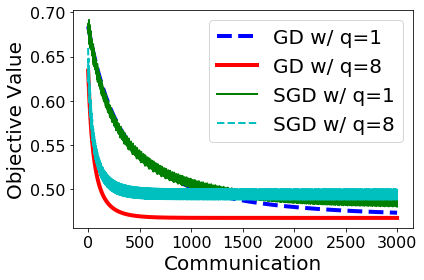

In [14]:
import matplotlib.pyplot as plt 
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd_sgd = range(communication)

line0, = plt.plot(epochs_gd_sgd, GD_1, '--b', LineWidth=4)
line1, = plt.plot(epochs_gd_sgd, GD_8, '-r', LineWidth=4)
line2, = plt.plot(epochs_gd_sgd, SGD_1, '-g', LineWidth=2)
line3, = plt.plot(epochs_gd_sgd, SGD_8, '--c', LineWidth=2)

plt.xlabel('Communication', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0,line1,line2,line3], ['GD w/ q=1','GD w/ q=8','SGD w/ q=1','SGD w/ q=8'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)